KeyError: 'ratio_of_sentence_initial_conjunctions'

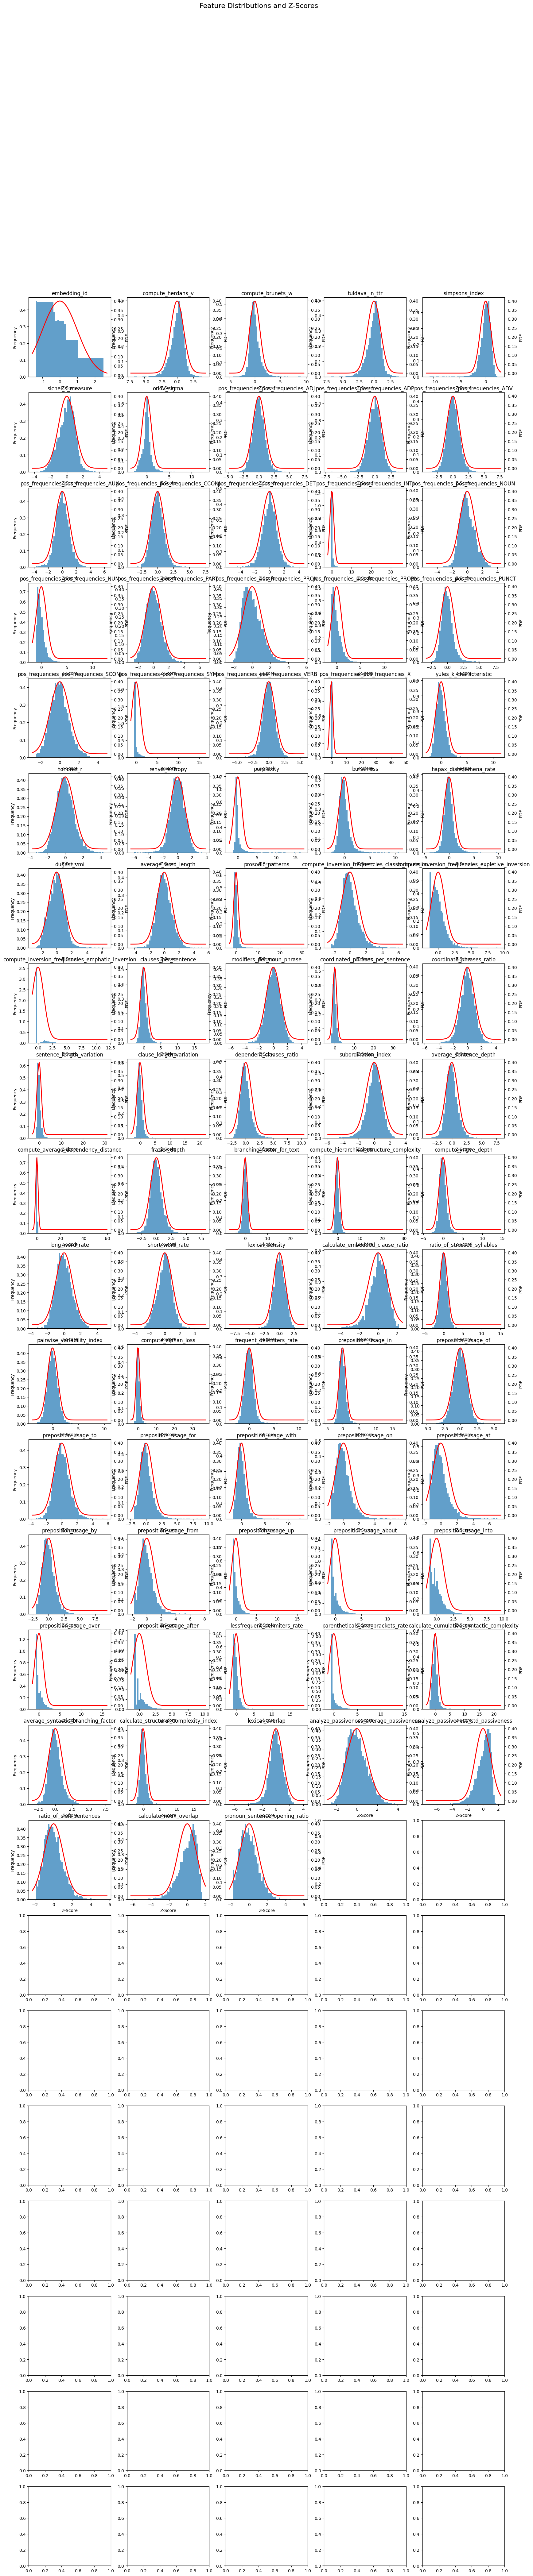

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

def load_and_combine_data(file_paths):
    dataframes = [pd.read_csv(file_path) for file_path in file_paths]
    return pd.concat(dataframes, ignore_index=True)

def calculate_statistics(combined_df):
    numeric_columns = combined_df.select_dtypes(include='number').columns
    stats_dict = {}

    for col in numeric_columns:
        if not np.all(combined_df[col] == 0):  # Skip columns with all zeros
            stats_dict[col] = {
                'mean': combined_df[col].mean(),
                'std': combined_df[col].std(),
                'percentile_95': np.percentile(combined_df[col], 95),
                'percentile_5': np.percentile(combined_df[col], 5)
            }

    return pd.DataFrame(stats_dict).T

def normalize_embedding(raw_embedding, stats_data):
    normalized_embedding = {}
    for col in raw_embedding.columns:
        if col in stats_data.index:
            mean = stats_data.at[col, 'mean']
            std = stats_data.at[col, 'std']
            percentile_95 = stats_data.at[col, 'percentile_95']
            percentile_5 = stats_data.at[col, 'percentile_5']
            
            if std != 0:
                zscore = (raw_embedding[col] - mean) / std
            else:
                zscore = 0
            
            normalized_value = (zscore - (percentile_5 - mean) / std) / ((percentile_95 - mean) / std - (percentile_5 - mean) / std)
            normalized_value = np.clip(normalized_value, 0, 1)
            
            normalized_embedding[col] = normalized_value
    
    return pd.DataFrame(normalized_embedding)

def visualize_features(combined_df, stats_data, output_file, dpi=300):
    numeric_columns = combined_df.select_dtypes(include='number').columns
    n_features = len(numeric_columns)
    n_cols = 5
    n_rows = (n_features - 1) // n_cols + 1

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 4*n_rows))
    fig.suptitle("Feature Distributions and Z-Scores", fontsize=16)

    for idx, col in enumerate(numeric_columns):
        ax = axes[idx // n_cols, idx % n_cols]
        
        mean = stats_data.at[col, 'mean']
        std = stats_data.at[col, 'std']
        z_scores = (combined_df[col] - mean) / std if std != 0 else np.zeros_like(combined_df[col])
        n, bins, _ = ax.hist(z_scores, bins=50, density=True, alpha=0.7)
        xmin, xmax = ax.get_xlim()
        x = np.linspace(xmin, xmax, 100)
        p = stats.norm.pdf(x, 0, 1)
        ax2 = ax.twinx()
        ax2.plot(x, p, 'r-', linewidth=2)
        
        ax.set_title(f"{col}")
        ax.set_xlabel("Z-Score")
        ax.set_ylabel("Frequency")
        ax2.set_ylabel("PDF")

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.savefig(output_file, dpi=dpi)
    plt.close()

def main():
    file_paths = [
        'ABB_30_embeddings.csv',
        'ABB_70_embeddings.csv',
        'AGG_30_embeddings.csv',
        'AGG_70_embeddings.csv'
    ]

    combined_df = load_and_combine_data(file_paths)
    stats_data = calculate_statistics(combined_df)
    stats_data.to_csv('embedding_stats.csv', index=True)

    visualize_features(combined_df, stats_data, 'feature_distributions.png', dpi=300)

    new_raw_embedding = pd.DataFrame({
        'feature1': [0.2, 0.4, 0.5],
        'feature2': [0.6, 0.7, 0.8],
                })
    normalized_embedding = normalize_embedding(new_raw_embedding, stats_data)
    print(normalized_embedding)

if __name__ == "__main__":
    main()